# Planar Flows Example in Pytorch

Robert Bridges, 10 Dec 2024 

Goal is to learn more about PyTorch implementation of Planar NFs via this 
- blog post https://vishakh.me/posts/normalizing_flows/ which implements planar flows from this paper https://arxiv.org/pdf/1505.05770.pdf in PyTorch
- and uses this corresponding code: https://github.com/VishakhG/normalizing-flows 

# Notation
Notation seems to follow Papamakarios et al.:
- $p_u(u,\phi)$ base distribution with variable $u$ and parameters $\phi$
- $T(\cdot, \theta):\mathbb{R}^n_u \to \mathbb{R}^n_x$ diffeomorphism with parameters $\theta$, $x$ is output variable ($T(u)  = x$)
- $p^*(x)$  target distribution 

Reverse KL Loss is 
$$\frac{1}{N}\sum_i \log p_u(u_i; \phi) -\log|\det(T'(u_i; \theta))| - \log(p_u^*(T(u_i; \theta))) $$

In our case we will not optimize $\phi$, so we ignore the first term and obtain: 
$$ - \frac{1}{N}\sum_i  \log|\det(T'(u_i; \theta))| + \log(p_u^*(T(u_i; \theta))) $$

## Planar Flow 
Our diffeomorphism, $ T = f_k\circ ... \circ f_1$ has all $f_j$ of the form: 
$$ \vec{u}\mapsto \vec{u} + h(\vec{w}^t \vec{u} + b) \vec{v} $$ 
where $\vec{w}\in \mathbb{R}^n, b \in \mathbb{R}, \vec{v}\in \mathbb{R}^n$ and $h$ is an activation function (e.g., $h = \tanh$ or $h= \text{sigmoid}$ componentwise.)

In [3]:
import torch, math
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib
import logging
logging.getLogger('matplotlib.font_manager').disabled = True # turns off warnings about fonts. 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #supress future warnings
import sys 
from pathlib import Path
# add our ./code/lr_experiment/ folder so we can find our config file 
sys.path.append(Path(".", "code", "lr_experiment").absolute().as_posix())
sys.path.append(Path(".", "code").absolute().as_posix())
from plotting_utils import plot_2D_potential, plot_2d_model_and_target


In [4]:
import seaborn as sns
# pretty palettes galore: https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
virdis = sns.color_palette("viridis", as_cmap=True)
rocket = sns.color_palette("rocket", as_cmap=True) # flare extended to black/white at ends
mako = sns.color_palette("mako", as_cmap=True) # crest extended to black/white at ends
magma = sns.color_palette("magma", as_cmap=True)
inferno = sns.color_palette('inferno', as_cmap = True)

Define potential functions (log (distribution)):

In [6]:
def pot_1(z):
    """Returns potential function (log of a probability up to a constant)

    Args: z (torch.array): of shape [num_rows, 2] (every row gives a point in the plane.)

    Returns:
        w (torch.array): of shape [num_rows] with potential values for each 2d point in z. 
    """
    z_1, z_2 = z[:, 0], z[:, 1]
    norm = torch.sqrt(z_1.pow(2) + z_2.pow(2))
    outer_term_1 = .5 * ((norm - 2) / .4) ** 2
    inner_term_1 = torch.exp((-.5 * ((z_1 - 2) / .6) ** 2))
    inner_term_2 = torch.exp((-.5 * ((z_1 + 2) / .6) ** 2))
    outer_term_2 = torch.log(inner_term_1 + inner_term_2 + 1e-7)
    u = outer_term_1 - outer_term_2
    return -u

def w_1(z):
    return torch.sin((2 * math.pi * z[:, 0]) / 4)


def w_2(z):
    return 3 * torch.exp(-.5 * ((z[:, 0] - 1) / .6).pow(2) )


sig = torch.nn.Sigmoid()

def w_3(z):
    return 3 * sig((z[:, 0] - 1) / .3)



def pot_2(z):
    """a potential function (log of numerator of a probability distribution)

    Args:
        z (torch.array): of shape [num_rows, 2] (every row gives a point in the plane.)

    Returns:
        w (torch.array): of shape [num_rows] with potential values for each 2d point in z. 
    """
    u = .5 * ((z[:, 1] - w_1(z)) / .4) ** 2
    return -u


def pot_3(z):
    term_1 = torch.exp(-.5 * (
        (z[:, 1] - w_1(z)) / .35) ** 2)
    term_2 = torch.exp(-.5 * (
        (z[:, 1] - w_1(z) + w_2(z)) / .35) ** 2)
    u = - torch.log(term_1 + term_2 + 1e-7)
    return - u


def pot_4(z):
    term_1 = torch.exp(-.5 * ((z[:, 1] - w_1(z)) / .4) ** 2)
    term_2 = torch.exp(-.5 * ((z[:, 1] - w_1(z) + w_3(z)) / .35) ** 2)
    u = - torch.log(term_1 + term_2)
    return - u

# below functions are for our utility functions, not from the paper

def pot_5(z): 
    X = torch.tensor([[-1.,1.], [1.,1.]])
    y = torch.tensor([0.,1.])

    y_preds = torch.sigmoid(torch.mm(X,z.T)) # shape is (2 by l): \phi(x^t b)  for each of the 2 data points x\in X, and for each of the l weight vectors b\in B, 

    # compute cross entropy loss for every beta given: 
    cel_fn = torch.nn.BCELoss(reduction = 'sum' ) ## instantiates binary cross entropy loss function class, see # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
    cels = torch.tensor([cel_fn(y_preds[:, j], y ) for j in range(y_preds.shape[1])]) # shape is l
    
    # compute l2 norm^2 of input
    z_1, z_2 = z[:, 0], z[:, 1]
    norm2 = z_1.pow(2) + z_2.pow(2)
    return -cels - .1* norm2


def pot_6(z): 
    X = torch.tensor([[-1.,1.], [1.,1.]])
    y = torch.tensor([0.,1.])

    y_preds = torch.sigmoid(torch.mm(X,z.T)) # shape is (2 by l): \phi(x^t b)  for each of the 2 data points x\in X, and for each of the l weight vectors b\in B, 

    # compute cross entropy loss for every beta given: 
    cel_fn = torch.nn.BCELoss(reduction = 'sum' ) ## instantiates binary cross entropy loss function class, see # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
    cels = torch.tensor([cel_fn(y_preds[:, j], y ) for j in range(y_preds.shape[1])]) # shape is l
    
    # compute l2 norm^2 of input
    z_1, z_2 = z[:, 0], z[:, 1]
    norm2 = z_1.pow(2) + z_2.pow(2)
    return (-cels*50 - norm2)/100

def pot_7(z): # same as pot_5, but with hand written cel
    X = torch.tensor([[-1.,1.], [1.,1.]])
    y = torch.tensor([0.,1.])

    y_preds = torch.sigmoid(torch.mm(X,z.T)) # shape is (2 by l): \phi(x^t b)  for each of the 2 data points x\in X, and for each of the l weight vectors b\in B, 
    neg_cels = torch.tensor( [ (y*torch.log(y_preds[:,j]) + (1-y)*torch.log(1-y_preds[:,j])).sum() for j in range(y_preds.shape[1]) ])
    
    # compute l2 norm^2 of input
    z_1, z_2 = z[:, 0], z[:, 1]
    norm2 = z_1.pow(2) + z_2.pow(2)
    
    return neg_cels -.1 * norm2


Plot the potentials: 

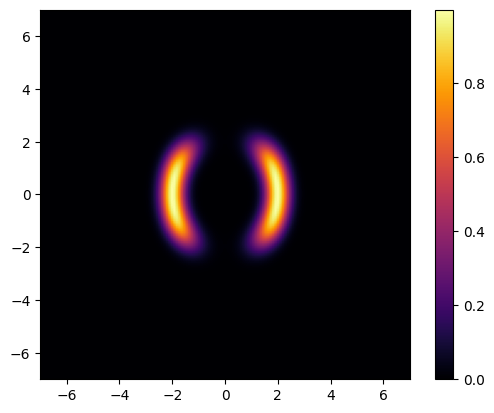

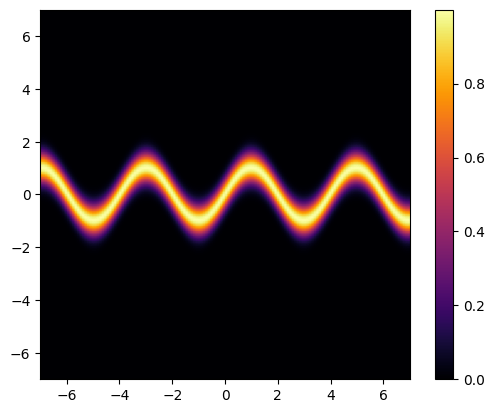

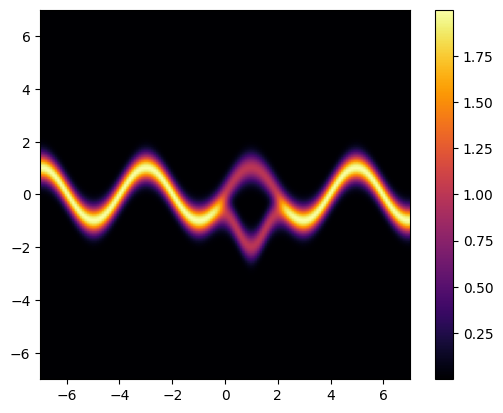

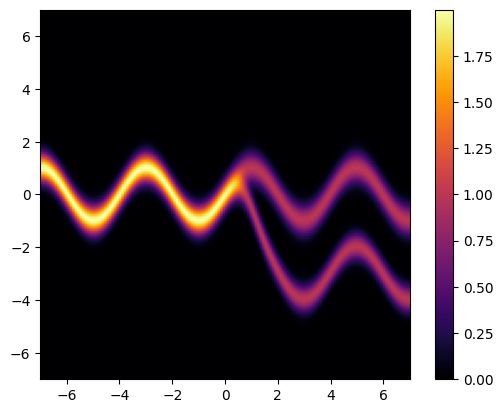

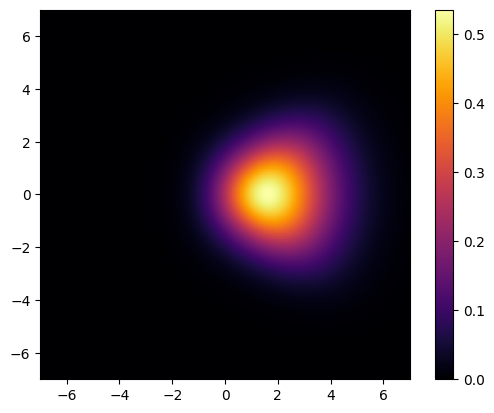

In [5]:
for pot in [pot_1, pot_2, pot_3, pot_4, pot_5]:#, pot_6, pot_7]:
    plot_2D_potential(pot, min = -7, max = 7)

In [7]:
import sys
from pathlib import Path
# add ./code/ folder to sys.path so we can import our own scripts
codepath = Path("./code").absolute().as_posix() 
sys.path.append(codepath)
from normalizing_flows import *

/Users/robertbridges/ctrl-allt-dela/normalizing-flows-tutorial/normalizing_flows.py:92: SyntaxWarning: invalid escape sequence '\c'
  """
/Users/robertbridges/ctrl-allt-dela/normalizing-flows-tutorial/normalizing_flows.py:263: SyntaxWarning: invalid escape sequence '\c'
  """


## Aside: Unit tests and simple exercises with Planar Flow code
Goal here is just to implement a 1 layer, 1 dimension (on $\mathbb{R}$) Planar Flow (called `test`), and make sure we understand some basics: 
- test.forward(z) should equal test(z) (same syntax i think)
- test.forward outputs T(z), log_det_T(z). We should be able to manually compute these and get the same answer. 
- If we make a loss function with T(z), or log_det_T(z), we should be able to see that the gradients of the parameters (w,u,b) get populated after calling a .backward. --> building confidence that PyTorch will train these parameters for us. 
  

In [8]:
test = NormalizingFlow(1, n_flows= 1)
for layer, p in enumerate(test.parameters()): 
    print(layer, p)

0 Parameter containing:
tensor([[0.0012]], requires_grad=True)
1 Parameter containing:
tensor([[-0.0055]], requires_grad=True)
2 Parameter containing:
tensor([-0.0069], requires_grad=True)


In [9]:
z = random_normal_samples(1,dim = 1)
print(z)
print(test(z))
pf = test.flows[0] # so we can access the parameters of the single layer by name. 


tensor([[0.6033]])
(tensor([[0.6033]], grad_fn=<AddBackward0>), tensor([[-6.7950e-06]], grad_fn=<AddBackward0>))


In [10]:
# should match:
print(z+torch.tanh(( torch.mm(pf.w.T,z) + pf.b) ) *(pf.u))
print(test.forward(z)[0])

tensor([[0.6033]], grad_fn=<AddBackward0>)
tensor([[0.6033]], grad_fn=<AddBackward0>)


In [11]:
# parameter gradients should be None until a .backward() is called: 
print(pf.w.grad, pf.u.grad, pf.b.grad)


None None None


In [12]:
x, log_det_j = test.forward(z)
det_j = torch.exp(log_det_j)

In [13]:
loss = test.forward(z)[0].mean()
loss.backward()

In [14]:
print(loss, x.mean()) # should match
print(pf.w.grad, pf.u.grad, pf.b.grad) # should be populated now

tensor(0.6033, grad_fn=<MeanBackward0>) tensor(0.6033, grad_fn=<MeanBackward0>)
tensor([[0.0008]]) tensor([[-0.0102]]) tensor([0.0012])


In [15]:
# T' by hand and by the class method should match:
print(torch.abs(torch.mm(pf.w.T , pf.u)*(1 - ( pf.h( torch.mm(pf.w.T,z) + pf.b ) ).pow(2) ) + 1))
print(det_j)

tensor([[1.0000]], grad_fn=<AbsBackward0>)
tensor([[1.0000]], grad_fn=<ExpBackward0>)


There are only two methods in the Normalizing Flow class, .forward, and .sample. But .sample is just a portion of the .forward class (although the log_det_jac isn't computed, so faster to call this when not computing reverse KL loss.)

In [16]:
z = random_normal_samples(2, dim = 1)
test(z) # uses .forward

(tensor([[-0.1313],
         [ 0.5939]], grad_fn=<AddBackward0>),
 tensor([[-6.7950e-06],
         [-6.7950e-06]], grad_fn=<AddBackward0>))

In [17]:
test.sample(z) # pushes z thru T but doesn't compute the log_det_jac(T)

tensor([[-0.1313],
        [ 0.5939]], grad_fn=<AddBackward0>)

## Example

Here we train an NF (with only planar flows) for potential function 1.  
Note that the hyper parameters for training are from the Rezende et al. paper 
500K epochs takes a long time! it may want to be reduced for learning/interactive uses. 

In [18]:
# hyperparameters for model: 
dim = 2
n_flows = 4

# hyperparameters for training (# from Rezende et al.)
learning_rate = 1e-3
momentum = .9
epochs = 20000 # will have 1 batch per epoch
batch_size = 400 # number of samples to use per batch = per epoch

target_density = pot_1 # function that returns log(constant * probability density) 


In [19]:
#instantiate model, optimizer, and list to store losses
model = NormalizingFlow(dim, n_flows=n_flows) #dimension is 2, number of layers/flows = n_flows

# RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params = model.parameters(),
    lr = learning_rate,
    momentum = momentum
)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(opt, 'min', patience=1000)

losses = [] # to be populated

Recall our goal is to learn the parameters of the model to minimize the Reverse KL: 
$$ - \frac{1}{N}\sum_i  \log|\det(T'(u_i; \theta))| + \log(p_u^*(T(u_i; \theta))) $$

For each epoch we will: 
- Sample a batch from the base distribution $u_i\sim p_u$;
- Compute the RKL value (eqn. above)---this has three substeps
  - call the model.forward(samples) which produces two tensors, the [log_det_T(u_i)] tensor (needed for the term of the sum), and the pushforward  [x_i = T(u_i)] tensor (needed for the second sum)
  - call $\log(p^*(x_i))$ to get the needed tensor of values ([p*(x_i)]) for the second term. 
  - sum the two tensors, and take the negative average of them. 
- Take a step of our parameters: 
  - zero out the gradients in the optimizer / model (have to do this every step)
  - call loss.backward() to populated gradients in optimizer/model 
  - call opt.step() to step! 

In [22]:
for epoch in range(epochs):

    # samples = torch.autograd.Variable(random_normal_samples(batch_size)) # Variables is deprecated and i think this is unnecessary
    samples = random_normal_samples(batch_size, dim = dim) # {u_i} sampled from base. 

    # compute  RKL loss function: 
    x, log_det_T = model(samples) # we need the log_det_T and the x_i = T(u_i) 
    log_p_x = target_density(x) # p*(x_i), needed for loss function
    loss = -(log_det_T + log_p_x).sum() # Reverse KL

    # take a step: 
    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")


Epoch 0, Loss 185916.625
Epoch 1000, Loss 186936.34375
Epoch 2000, Loss 193328.875
Epoch 3000, Loss 186349.765625
Epoch 4000, Loss 177180.5625
Epoch 5000, Loss 163988.265625
Epoch 6000, Loss 167503.71875
Epoch 7000, Loss 189513.734375
Epoch 8000, Loss 159307.9375
Epoch 9000, Loss 178214.25
Epoch 10000, Loss 165969.1875
Epoch 11000, Loss 171458.9375
Epoch 12000, Loss 186869.140625
Epoch 13000, Loss 198892.03125
Epoch 14000, Loss 172096.453125
Epoch 15000, Loss 180598.765625
Epoch 16000, Loss 179968.0
Epoch 17000, Loss 171062.34375
Epoch 18000, Loss 187269.5625
Epoch 19000, Loss 198777.59375


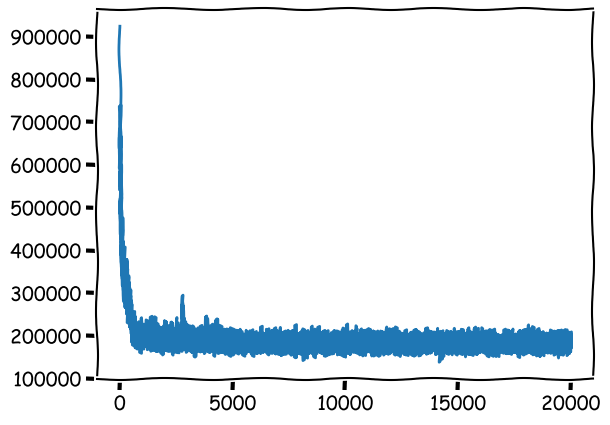

/Users/robertbridges/ctrl-allt-dela/normalizing-flows-tutorial/.venv/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


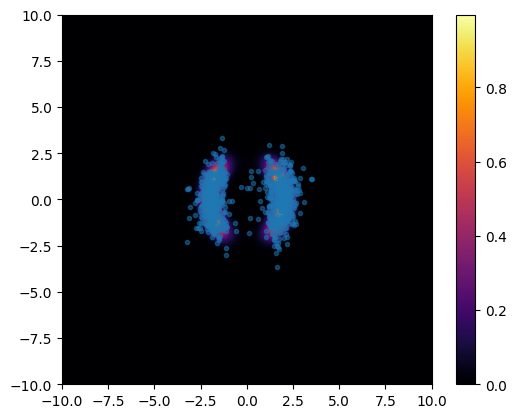

/Users/robertbridges/ctrl-allt-dela/normalizing-flows-tutorial/plotting_utils.py:184: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.figure.show()


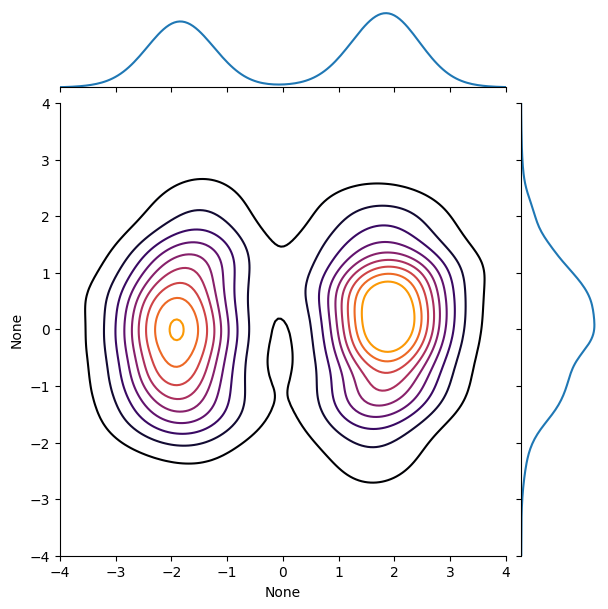

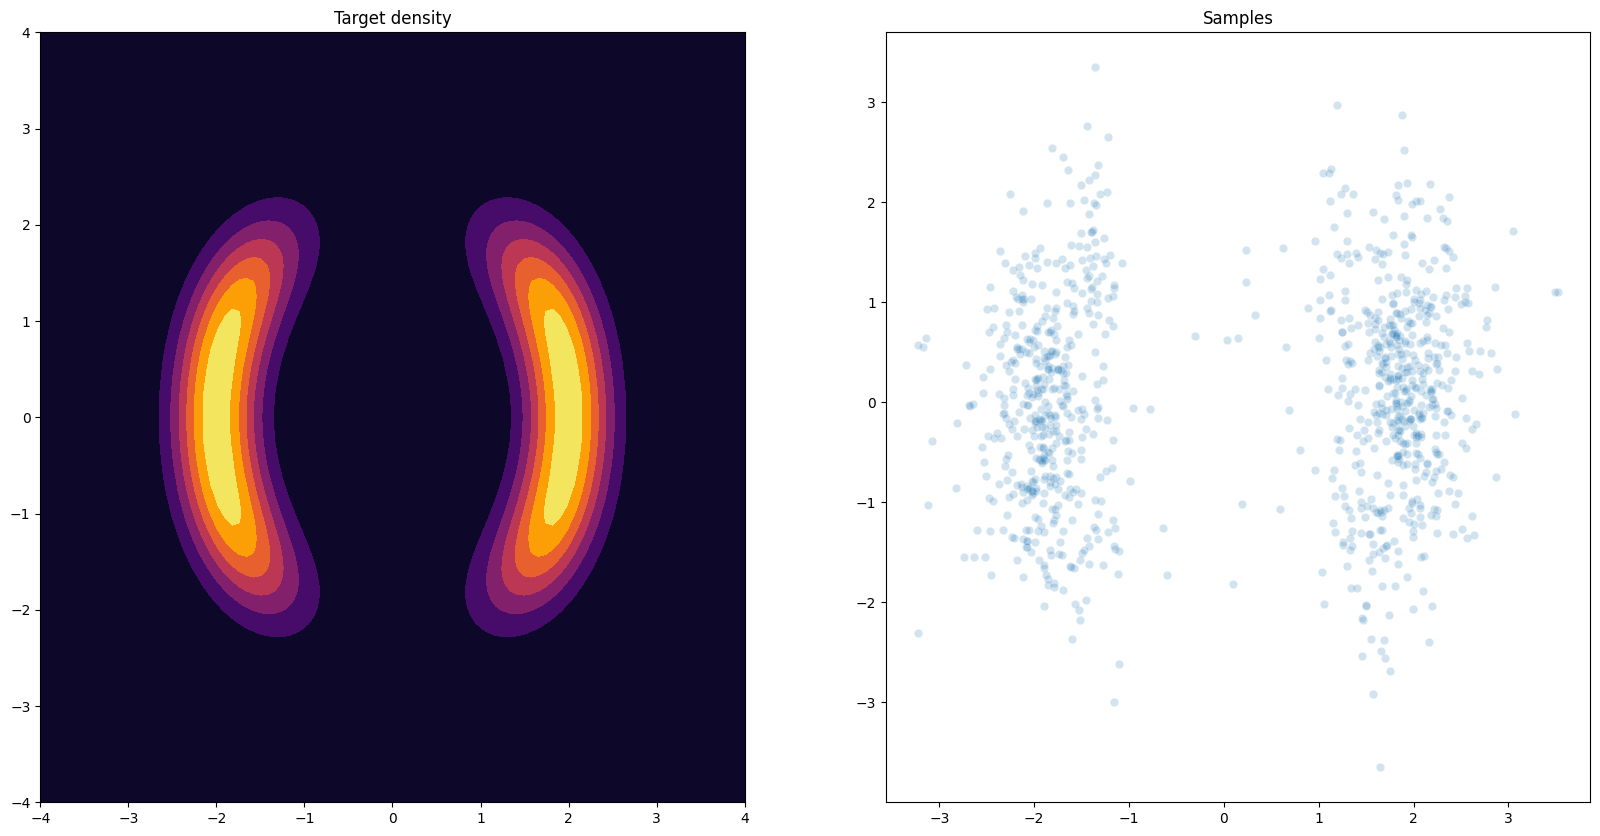

In [21]:
len(losses)
with plt.xkcd():
    plt.plot(range(len(losses)), losses)
    plt.show()
    
plot_2d_model_and_target(target_density, model, min = -10, max = 10, N = 1000)